In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

import time
from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
from configs.seq_multichannel_biogas import hparams
hparams = hparams()

### Define Data Generator

In [3]:
from data_loader.biogas import *
dataset, dataset_val, dataset_test = load_data(hparams)

### Define Model

In [4]:
def gru(units, name):
    # Use CuDNNGRU is GPU is available (provides a 3x speedup than GRU)
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_activation='relu',
                                        recurrent_initializer='glorot_uniform',
                                        name=name)
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='relu', 
                                   recurrent_initializer='glorot_uniform',
                                   name=name)

In [5]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, name=None):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units, name=name + '_W1')
        self.W2 = tf.keras.layers.Dense(units, name=name + '_W2')
        self.V = tf.keras.layers.Dense(1, name=name + '_V')

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.expand_dims(context_vector, 1)

        return context_vector, attention_weights

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self, output_dim, layers, units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.layer_s = layers
        self.units = units
        self.cells = [gru(self.units, 'encoder_gru_%i' % i) for i in range(layers)]
        
    def call(self, x, hidden):
        outputs, states = [], []
        output = x
        
        for cell in self.cells:
            output, state = cell(output, initial_state = hidden)
            outputs.append(output)
            states.append(state)

        return outputs, states
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [7]:
class Decoder(tf.keras.Model):
    def __init__(self, output_dim, layers, neurons_unit, batch_size):
        super(Decoder, self).__init__()
        self.output_dim   = output_dim
        self.num_layers   = num_layers
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.cells = [gru(neurons_unit, 'decoder_gru_%i' % i) for i in range(layers)]
        self.attentions = [BahdanauAttention(neurons_unit, 'decoder_attn_%i' % i) for i in range(layers)]
        self.fc_out = tf.keras.layers.Dense(output_dim, activation='relu', name='decoder_affine_out')
                
    def call(self, x, dec_states, enc_outputs, mask):
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        dec_output = x
        states = []
        
        for layer, cell in enumerate(self.cells):
            context_vector, _ = self.attentions[layer](enc_outputs[layer], dec_states[layer])
        
            # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
            dec_output = tf.concat([context_vector, dec_output], axis=-1)

            # passing the concatenated vector to the GRU
            dec_output, dec_state = self.cells[layer](dec_output, initial_state=dec_states[layer])
            dec_states.append(dec_state)
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc_out(dec_output) * mask
        
        return x, dec_states
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [8]:
class DecoderV2(tf.keras.Model):
    def __init__(self, output_dim, layers, units, batch_size):
        super(DecoderV2, self).__init__()
        self.batch_size = batch_size
        self.layer_s = layers
        self.units = units
        self.cells = [gru(self.units, 'decoder_gru_%i' % i) for i in range(layers)]
        self.attentions = [BahdanauAttention(self.units, 'decoder_attn_enc_%i' % i) for i in range(layers)]
        self.inp_attention = BahdanauAttention(self.units, 'decoder_attn_inp_%i' % i)
        self.fc_out = tf.keras.layers.Dense(output_dim, activation='relu', name='decoder_affine_out')
                
    def call(self, x, inp, dec_states, enc_outputs, mask):
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        context_vector_inp, _ = self.inp_attention(tf.reshape(inp, [self.batch_size, -1]), tf.reshape(inp, [self.batch_size, -1]))
        dec_output = x

        states = []
        
        for layer, cell in enumerate(self.cells):
            context_vector_enc, _ = self.attentions[layer](enc_outputs[layer], dec_states[layer])

            # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
            dec_output = tf.concat([context_vector_enc, dec_output], axis=-1)

            # passing the concatenated vector to the GRU
            dec_output, dec_state = self.cells[layer](dec_output, initial_state=dec_states[layer])
            dec_states.append(dec_state)
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc_out(dec_output) * mask
        
        return x, dec_states
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [28]:
class EncoderDecoder(tf.keras.Model):
    def __init__(self, output_dim, num_layers, neurons_unit, batch_size):
        super(EncoderDecoder, self).__init__()
        self.output_dim   = output_dim
        self.num_layers   = num_layers
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size

        self.encoder = Encoder(output_dim, num_layers, neurons_unit, batch_size)
        self.decoder = Decoder(output_dim, num_layers, neurons_unit, batch_size)
    
    def call(self, inp):
        hidden = self.encoder.initialize_hidden_state()
        enc_output, enc_hidden = self.encoder(inp, hidden)

        dec_hidden = enc_hidden

        dec_input = tf.concat((inp[:,0,:], tf.expand_dims(inp[:,-1,-1], 1)), axis=1)
        dec_input = tf.expand_dims(dec_input, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(0, inp.shape[1]):
            # passing enc_output to the decoder
            prediction, dec_hidden = self.decoder(dec_input, dec_hidden, enc_output, mask[:,t:t+1])

            # using teacher forcing - adapted to feed predictions
            dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), prediction), axis=2)
            
            if t == 0:
                predictions = prediction
            else:
                predictions = tf.concat([predictions, prediction], axis=1)
        
        return predictions

### Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

In [9]:
def loss_function(real, preds, variables, lambd = 1e-4):
    # Calculate OLS loss
    mse_loss = tf.losses.mean_squared_error(labels=real, predictions=preds)
    
    sum_mse_loss = tf.losses.mean_squared_error(tf.reduce_mean(real,  axis=(0,2)),
                                                tf.reduce_mean(preds, axis=(0,2)))

    # Add L2 Regularisation
    l2_loss = 0
    for var in variables:
        l2_loss += lambd * tf.reduce_sum(var ** 2)

    #accuracy, loss = mse_loss, mse_loss + sum_mse_loss + l2_loss
    accuracy, loss = mse_loss, mse_loss + l2_loss
    return loss, accuracy

In [35]:
def train_model(model, optimizer, dataset, hparams, epochs = 10, verbose = True, lambd=10e-4):

    # start timer
    training_run_start = time.time()
    stats = []

    for epoch in range(epochs):
        epoch_start = time.time()

        total_loss, total_accuracy = 0, 0

        for (batch, (inp, targ, mask)) in enumerate(dataset):
            with tf.GradientTape() as tape:
                pred = model(inp)
                loss, accuracy = loss_function(targ, pred, model.variables, lambd=lambd)

            # update statistics
            total_loss     += (loss     / int(targ.shape[1]))
            total_accuracy += (accuracy / int(targ.shape[1]))

            # update gradients
            variables = model.variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))

        if verbose:
            print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                100 * total_loss / (batch+1), 100 * total_accuracy / (batch+1)))
            print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - epoch_start))
        
        # apply learning rate decay
        optimizer._lr *= hparams.lr_decay
        stats.append([total_loss / (batch+1), total_accuracy / (batch+1), time.time() - epoch_start])
    
    return total_loss / (batch+1), total_accuracy / (batch+1), time.time() - training_run_start, np.array(stats)

Run a training session and print training statistics and model structure

Epoch 1 Loss 0.3916 Accuracy 0.0463
Time taken for 1 epoch 51.4488 sec

Epoch 2 Loss 0.1068 Accuracy 0.0010
Time taken for 1 epoch 51.4977 sec

Loss 0.1068 Accuracy 0.0010 Time 102.9470


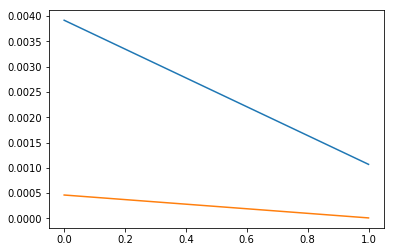

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_8 (Encoder)          multiple                  3648      
_________________________________________________________________
decoder_8 (Decoder)          multiple                  8994      
Total params: 12,642
Trainable params: 12,642
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = EncoderDecoder(hparams.output_dim, hparams.num_layers, hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = train_model(model, optimizer, dataset, hparams, epochs=2, verbose=True)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
plt.plot(stats[:,:2])
plt.show()

model.summary()

In [284]:
# Start training run
# Initialise model and optimiser
loss, accuracy, run_time, stats = train_model(model, optimizer, dataset, hparams, epochs=100, verbose=True, lambd=1e-5)

Epoch 1 Loss 2.2325 Accuracy 1.7114
Time taken for 1 epoch 23.7321 sec

Epoch 2 Loss 2.2289 Accuracy 1.7086
Time taken for 1 epoch 21.6430 sec

Epoch 3 Loss 2.2252 Accuracy 1.7057
Time taken for 1 epoch 18.5605 sec

Epoch 4 Loss 2.2216 Accuracy 1.7028
Time taken for 1 epoch 20.6166 sec

Epoch 5 Loss 2.2179 Accuracy 1.6999
Time taken for 1 epoch 20.9444 sec

Epoch 6 Loss 2.2143 Accuracy 1.6969
Time taken for 1 epoch 20.3896 sec

Epoch 7 Loss 2.2105 Accuracy 1.6938
Time taken for 1 epoch 20.8770 sec

Epoch 8 Loss 2.2067 Accuracy 1.6907
Time taken for 1 epoch 21.6136 sec

Epoch 9 Loss 2.2029 Accuracy 1.6876
Time taken for 1 epoch 22.4096 sec

Epoch 10 Loss 2.1990 Accuracy 1.6843
Time taken for 1 epoch 20.7673 sec

Epoch 11 Loss 2.1949 Accuracy 1.6809
Time taken for 1 epoch 20.5755 sec

Epoch 12 Loss 2.1910 Accuracy 1.6775
Time taken for 1 epoch 23.4489 sec

Epoch 13 Loss 2.1870 Accuracy 1.6741
Time taken for 1 epoch 18.3132 sec

Epoch 14 Loss 2.1831 Accuracy 1.6707
Time taken for 1 epoch 

In [ ]:
START_POINT = 0
total_accuracy = []

for i, (inp, target, mask) in enumerate(dataset_val):
    forecast = []

    hidden = encoder.initialize_hidden_state()
    enc_output, enc_hidden = encoder(inp[:, START_POINT:], hidden)

    dec_hidden = enc_hidden

    dec_input = tf.concat((inp[:,0,:], tf.expand_dims(inp[:,-1,-1], 1)), axis=1)
    dec_input = tf.expand_dims(dec_input, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, target.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output, mask[:,t:t+1])
        forecast.append(np.squeeze(predictions))

        # using teacher forcing - adapted to feed predictions
        dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), predictions), axis=2)

    accuracy = (np.array(forecast).T - target[:,:60,0]) * x_max
    accuracy = accuracy ** 2 / x_var
    accuracy = np.mean(accuracy, axis=0)
    
    total_accuracy.append(accuracy)

model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))
    
print('Total Accuracy: %.4f' % np.mean(total_accuracy))
plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

In [ ]:
plt.figure()
for t, data in model_accuracy:
    plt.plot(data, label = 'Training Set: %i hrs' % t)
plt.legend()
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('Relative Squared Error')
plt.title('Encoder-Decoder Network')
plt.plot()

### Test Hyperparameters

In [208]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

#for _ in range(25):
#   lr = np.random.uniform(-8, -1, 1):
#   nodes = np.floor(2 ** np.random.randint((3,9))):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    encoder_ = Encoder(hparams.output_dim, hparams.num_layers, int(nodes), hparams.batch_size)
    decoder_ = Decoder(hparams.output_dim, hparams.num_layers, int(nodes), hparams.batch_size)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        train_model((encoder_, decoder_), optimizer_, dataset, hparams, epochs = 5, verbose=False)
    print('Learning Rate {:.4f} Nodes {} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(\
                lr, nodes, loss*100, accuracy * 100, run_time))
    
    models.append((encoder_,decoder_))
    stats.append(stat)

Learning Rate -4.0000 Nodes 32 Loss 27.8983 Accuracy 20.0464 Time 49.0
Learning Rate -3.5000 Nodes 32 Loss 21.9999 Accuracy 14.1988 Time 48.6
Learning Rate -3.0000 Nodes 32 Loss 13.1795 Accuracy 5.5426 Time 53.0
Learning Rate -2.5000 Nodes 32 Loss 12.6493 Accuracy 5.5474 Time 49.3
Learning Rate -2.0000 Nodes 32 Loss 15.3639 Accuracy 9.3260 Time 49.6
Learning Rate -1.5000 Nodes 32 Loss 25.8809 Accuracy 20.7164 Time 44.0
Learning Rate -1.0000 Nodes 32 Loss nan Accuracy nan Time 45.1
Learning Rate -0.5000 Nodes 32 Loss nan Accuracy nan Time 47.9


### Make Predictions

In [285]:
# empty string to store our results
START_POINT = 0
forecast = []

_, (inp, target, mask) = enumerate(dataset).__next__()

hidden = encoder_.initialize_hidden_state()
enc_output, enc_hidden = encoder_(inp[:, START_POINT:], hidden)

dec_hidden = enc_hidden

dec_input = tf.concat((inp[:,0,:], tf.expand_dims(inp[:,-1,-1], 1)), axis=1)
dec_input = tf.expand_dims(dec_input, 1)

# Teacher forcing - feeding the target as the next input
for t in range(1, target.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden = decoder_(dec_input, dec_hidden, enc_output, mask[:,t:t+1])
    forecast.append(np.squeeze(predictions))

    _, _ = loss_function(target[:, t:t+1], predictions, encoder_.variables + decoder_.variables)

    # using teacher forcing - adapted to feed predictions
    dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), predictions), axis=2)

forecast = np.array(forecast)

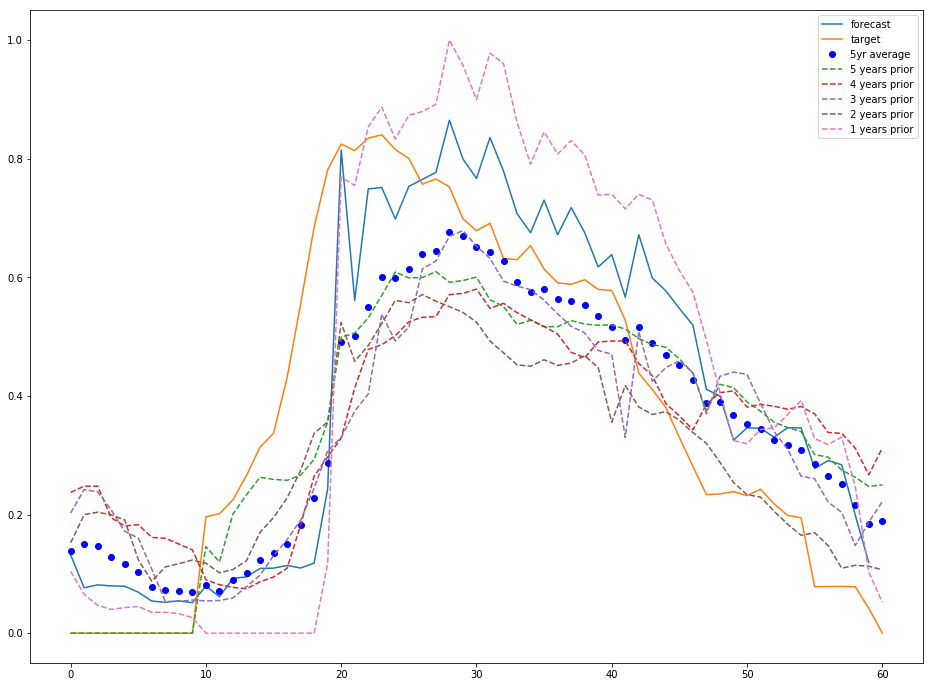

In [292]:
# empty string to store our results
TARGET_INDEX = 12
START_POINT = 0

# show target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[:,TARGET_INDEX]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX], 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i], '--', label='%i years prior' % (5-i))
plt.legend()
plt.show()

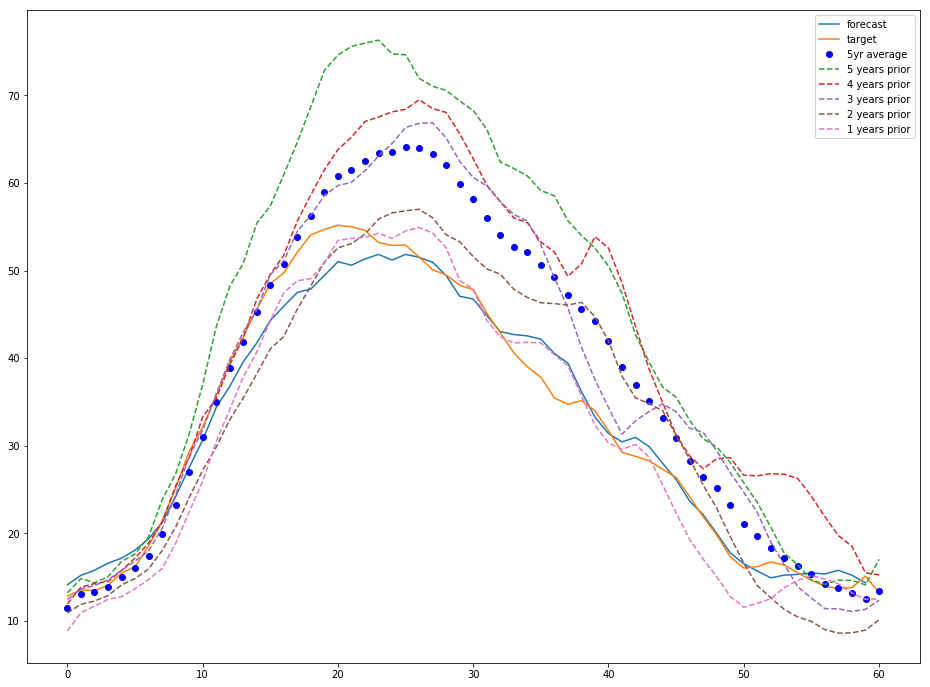

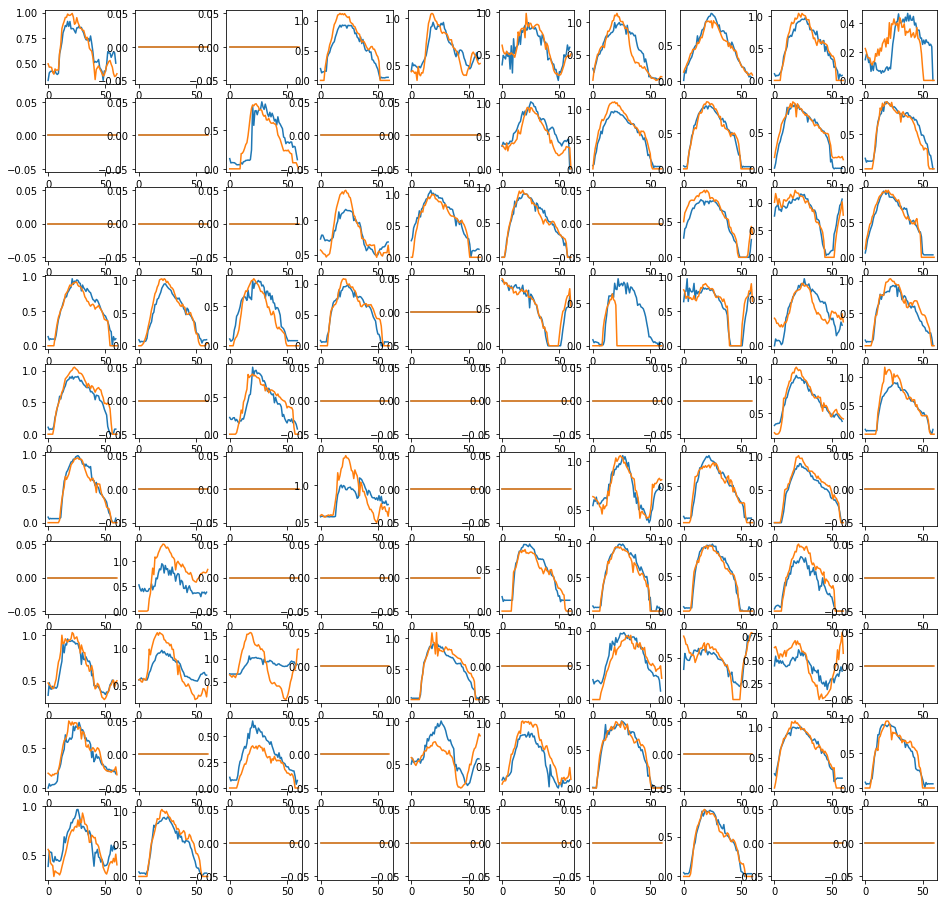

In [287]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(forecast, axis=1), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.sum(inp, axis=0)[:,i], '--', label='%i years prior' % (5-i))

plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,100):
    ax = plt.subplot(10,10,i+1)
    ax.plot(np.squeeze(forecast[:,i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

In [25]:
l_ = np.sum((forecast.T - np.squeeze(target)[:,:-1]) ** 2, axis=1)
l_.argsort()

array([ 0, 45, 46, 47, 48, 98, 53, 54, 56, 57, 61, 62, 64, 65, 66, 71, 75,
       77, 81, 83, 85, 89, 94, 95, 96, 97, 43, 36, 49, 23, 12, 15, 16, 22,
       28, 24, 13,  1,  3,  4, 67, 68, 34, 19, 52, 88, 69, 76, 35, 60, 27,
       82, 99, 92, 51, 11,  7, 93, 84, 37, 40, 32, 21, 10, 59, 70, 29, 41,
       91,  9, 18, 42, 31, 17, 79, 78, 39, 26,  6, 20, 80, 30, 87, 90, 86,
        2, 33, 58,  5,  8, 14, 44, 25, 38, 72, 50, 63, 73, 55, 74])

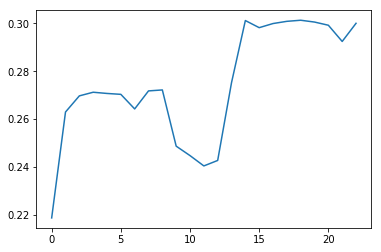

In [68]:
loss = np.mean((forecast.T*8.15 - target[:,1:,0]*8.15) ** 2 / dataset.var(), axis=0)
plt.plot(loss)
plt.show()

Adapted from examples contained in the official Tensorflow github repo;
<href>https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb</href>